In [1]:
import os
# to use or not to use GPU
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

# packages for model graph visualization
#!pip install -q pydot
# install graphviz https://graphviz.gitlab.io/download/ 

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub
!pip install -q -U tensorflow-text
import tensorflow_text as text
!pip install -q tf-models-official
from official.nlp import optimization  # to create AdamW optimizer

import json
import re
import random
import numpy as np
import matplotlib.pyplot as plt

#save_path = "/content/drive/My Drive/Colab Notebooks/"

     |████████████████████████████████| 4.9 MB 5.2 MB/s 
     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 42.5 MB/s 
     |████████████████████████████████| 213 kB 50.3 MB/s 
     |████████████████████████████████| 90 kB 9.1 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 47.7 MB 2.5 MB/s 
     |████████████████████████████████| 1.1 MB 48.4 MB/s 
     |████████████████████████████████| 352 kB 54.3 MB/s 
     |████████████████████████████████| 99 kB 10.2 MB/s 
     |████████████████████████████████| 596 kB 53.4 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
save_path = "/content/drive/My Drive/Colab Notebooks/"

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
# checking if we have access to a GPU

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
#@title Data Loading & Preprocessing


In [7]:
with open(save_path+'kafka_data_preprocessed_high_occurrence_50.json') as f:
    data = json.load(f)
    # shuffle data
    random.shuffle(data)
    # create description and assignee list
    desc_data = []
    assignee_data = []
    for item in data:
        desc_data.append(item['description'])
        assignee_data.append(item['assignee'])

In [8]:
print('sample assignees:', assignee_data[0:2])
print('sample descriptions:', desc_data[0:2])

sample assignees: ['Jason Gustafson', 'A. Sophie Blee-Goldman']
sample descriptions: ['For KIP-320, we changed the permissions of the OffsetsForLeaderEpoch to be topic-level so that consumers did not require Cluster permission. However, there is no way for a consumer to know whether the broker is new enough to support this permission scheme. The only way to be sure is to use the version of this API that was bumped in 2.3. For older versions, we should revert to the old behavior.', "To avoid triggering auto topic creation (if `auto.create.topic.enable=true` on the brokers), Kafka Streams uses consumer pattern subscription. For this case, the consumer requests all metadata from the brokers and does client side filtering. However, if users want to set ACL to restrict a Kafka Streams application, this may results in broker side ERROR logs that some metadata cannot be provided. The only way to avoid those broker side ERROR logs is to grant corresponding permissions. As of 2.3 release it's p

In [9]:
# transform description data to tensorflow dataset
descriptions = tf.data.Dataset.from_tensor_slices(desc_data)
for input in descriptions.take(2):
    print(input)

tf.Tensor(b'For KIP-320, we changed the permissions of the OffsetsForLeaderEpoch to be topic-level so that consumers did not require Cluster permission. However, there is no way for a consumer to know whether the broker is new enough to support this permission scheme. The only way to be sure is to use the version of this API that was bumped in 2.3. For older versions, we should revert to the old behavior.', shape=(), dtype=string)
tf.Tensor(b"To avoid triggering auto topic creation (if `auto.create.topic.enable=true` on the brokers), Kafka Streams uses consumer pattern subscription. For this case, the consumer requests all metadata from the brokers and does client side filtering. However, if users want to set ACL to restrict a Kafka Streams application, this may results in broker side ERROR logs that some metadata cannot be provided. The only way to avoid those broker side ERROR logs is to grant corresponding permissions. As of 2.3 release it's possible to disable auto topic creation c

In [10]:
# target vectorize assignee data
assignee_dict = {assignee: i for i, assignee in enumerate(list(set(assignee_data)))}
assignee_dict



{'A. Sophie Blee-Goldman': 26,
 'Apurva Mehta': 33,
 'Ashish Singh': 7,
 'Bill Bejeck': 6,
 'Boyang Chen': 30,
 'Bruno Cadonna': 23,
 'Chia-Ping Tsai': 4,
 'Chris Egerton': 29,
 'Colin McCabe': 34,
 'Damian Guy': 32,
 'David Jacot': 20,
 'Dong Lin': 9,
 'Dongjin Lee': 19,
 'Eno Thereska': 2,
 'Ewen Cheslack-Postava': 5,
 'Grant Henke': 25,
 'Guozhang Wang': 14,
 'Gwen Shapira': 0,
 'Harsha': 8,
 'Ismael Juma': 1,
 'Jason Gustafson': 28,
 'Jay Kreps': 31,
 'Jiangjie Qin': 18,
 'John Roesler': 10,
 'Jun Rao': 16,
 'Konstantine Karantasis': 24,
 'Luke Chen': 3,
 'Manikumar': 27,
 'Matthias J. Sax': 21,
 'Neha Narkhede': 22,
 'Rajini Sivaram': 12,
 'Randall Hauch': 17,
 'Swapnil Ghike': 11,
 'Tom Bentley': 13,
 'Vahid Hashemian': 35,
 'huxihx': 15}

In [11]:
# create target vector
assignee_vector = [assignee_dict[assignee] for assignee in assignee_data]
assignee_vector[:10]

[28, 26, 11, 17, 34, 1, 7, 16, 31, 22]

In [12]:
# assignee target vector to one hot vector
assignee_tensor = tf.data.Dataset.from_tensor_slices(assignee_vector)
assignee_one_hot = assignee_tensor.map(lambda x: tf.one_hot(x, len(assignee_dict)))
for assignee in assignee_one_hot.take(5):
    print(assignee)

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(36,), dtype=float32)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(36,), dtype=float32)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(36,), dtype=float32)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(36,), dtype=float32)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(36,), dtype=float32)


In [13]:
# zip descriptions and assignee for training
dataset = tf.data.Dataset.zip((descriptions, assignee_one_hot))
for input, target in dataset.take(2):
    print(input)
    print(target)

tf.Tensor(b'For KIP-320, we changed the permissions of the OffsetsForLeaderEpoch to be topic-level so that consumers did not require Cluster permission. However, there is no way for a consumer to know whether the broker is new enough to support this permission scheme. The only way to be sure is to use the version of this API that was bumped in 2.3. For older versions, we should revert to the old behavior.', shape=(), dtype=string)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(36,), dtype=float32)
tf.Tensor(b"To avoid triggering auto topic creation (if `auto.create.topic.enable=true` on the brokers), Kafka Streams uses consumer pattern subscription. For this case, the consumer requests all metadata from the brokers and does client side filtering. However, if users want to set ACL to restrict a Kafka Streams application, this may results in broker side ERROR logs that some metadata cannot be provided. The

In [14]:
# shuffle dataset
data_len = len(dataset)
dataset = dataset.shuffle(data_len)


In [15]:
# split dataset into train val and test
BATCH_SIZE = 32
VAL_SIZE = 0.15
n_examples = tf.data.experimental.cardinality(dataset).numpy()
print('n_examples:', n_examples)

VAL_SIZE = round(VAL_SIZE*n_examples)
test_dataset = dataset.take(VAL_SIZE).batch(batch_size=BATCH_SIZE, drop_remainder=True)
val_dataset = dataset.skip(VAL_SIZE).take(VAL_SIZE).batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_dataset = dataset.skip(VAL_SIZE*2).batch(batch_size=BATCH_SIZE, drop_remainder=True)


n_examples: 4338


In [16]:
# prefetch train val and test dataset
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

print('len(train_dataset):', len(train_dataset))
print('len(val_dataset):', len(val_dataset))
print('len(test_dataset):', len(test_dataset))


len(train_dataset): 94
len(val_dataset): 20
len(test_dataset): 20


In [17]:
# some train dataset examples
for input, target in train_dataset.take(2):
    print(input)
    print(target)

tf.Tensor(
[b"Users often want to read topic multiple times. However, this is not possible because there is a single consumer and thus a topic can only be consumed once. Users get an exception {quote}Exception in thread \xe2\x80\x9cmain\xe2\x80\x9d org.apache.kafka.streams.errors.TopologyException: Invalid topology: Topic source has already been registered by another source. {quote} If they use a topic name in multiple `stream()`, `table()`, `globalTable()` calls. However, with KAFKA-6034 in place, we could allow adding a topic multiple times and rewrite the topology internally to only read the topic once. This would simplify application code as users don't need to put workaround in place to get the same behavior."
 b'Currently it does not appear that the KafkaShortnamer allows for case insensitive search and replace rules. It would be good to match the functionality provided by HDFS as operators are familiar with this. This also makes it easier to port auth_to_local rules from your ex

BERT MODEL

In [18]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2' 

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'}

# find more models and preprocessing maps at 
# https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=en

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [19]:
# preprocessing examples
text_test = [input[0].numpy(), input[1].numpy()]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Lines      : {text_test}')
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   :')
print(f'{text_preprocessed["input_word_ids"][:, :12]}')
print(f'Input Mask :')
print(f'{text_preprocessed["input_mask"][:, :12]}')
print(f'Type Ids   :')
print(f'{text_preprocessed["input_type_ids"][:, :12]}')


Lines      : [b'This is an umbrella story for capturing changes to Kafka Streams to enable Queryable state as described in KIP-67 https://cwiki.apache.org/confluence/display/KAFKA/KIP-67%3A+Queryable+state+for+Kafka+Streams.', b'Pretty much as soon as we started actively monitoring the _last-rebalance-seconds-ago_ metric in our Kafka Streams test environment, we started seeing something weird. Every so often one of the StreamThreads (ie a single Consumer instance) would appear to permanently fall out of the group, as evidenced by a monotonically increasing _last-rebalance-seconds-ago._ We inject artificial network failures every few hours at most, so the group rebalances quite often. But the one consumer never rejoins, with no other symptoms (besides a slight drop in throughput since the remaining threads had to take over this member\'s work). We\'re confident that the problem exists in the client layer, since the logs confirmed that the unhealthy consumer was still calling poll. It wa

In [20]:
# model output examples

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Sequence Outputs Shape:(2, 128, 128)
Sequence Outputs Values:[[-0.8199718  -0.06247935 -3.4160364  ... -1.6043428  -1.8216697
   1.4438787 ]
 [-1.8183875   1.0086884   0.603252   ... -2.5280254  -1.550652
   0.4165143 ]
 [-1.3335456   0.9950316   0.23367187 ... -2.314034   -1.6054122
   0.39064446]
 ...
 [ 0.37140742  0.51852304 -0.26419178 ... -2.014215   -0.7632927
   1.3377297 ]
 [-0.19957796  0.33347338 -0.07792255 ... -1.583926   -1.9047812
   2.841353  ]
 [ 0.8625738   0.7430699  -0.6469157  ... -1.4979379  -1.8239652
   2.6709402 ]]
Pooled Outputs Shape:(2, 128)
Pooled Outputs Values:[-0.9999571   0.02029373 -0.865917    0.5325085  -0.8904524   0.8826034
 -0.71303236 -0.995001   -0.02119065 -0.03614308 -0.69785786 -0.08544977]


Classifier

In [21]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output'] 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(len(assignee_dict), activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [22]:
# building the classifier

bug_assignee_classifier = build_classifier_model()

bug_assignee_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [23]:
# classifier output examples

bert_raw_result = bug_assignee_classifier(tf.constant(text_test))
print(tf.nn.softmax(bert_raw_result))

tf.Tensor(
[[0.02376875 0.06116279 0.02803982 0.01546968 0.05811377 0.00842309
  0.00687862 0.02491615 0.02883748 0.1261643  0.0528581  0.01137536
  0.01097933 0.03139823 0.02767351 0.0143291  0.00196825 0.00763957
  0.06159985 0.00417969 0.051322   0.06009429 0.00891856 0.01083429
  0.01087304 0.05311107 0.00862431 0.0048587  0.00759663 0.01343136
  0.00751366 0.01122719 0.02806221 0.10479265 0.00729506 0.00566956]
 [0.01462017 0.04762396 0.01645673 0.02841918 0.08085826 0.0049979
  0.01313331 0.01415737 0.03057132 0.12987724 0.04235459 0.02769663
  0.01560683 0.02988086 0.02503457 0.02222097 0.00191087 0.01137038
  0.05191648 0.0059737  0.07414009 0.06073701 0.00482728 0.00651438
  0.00542167 0.04406381 0.01299875 0.00302255 0.01164023 0.01937752
  0.00497521 0.01213653 0.02317544 0.08592618 0.01228298 0.00407906]], shape=(2, 36), dtype=float32)


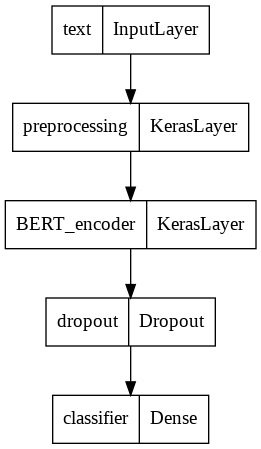

In [24]:
# plotting the model (requires pydot and graphviz)
tf.keras.utils.plot_model(bug_assignee_classifier)

In [ ]:
epochs = 15
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs

# Here we are using AdamW with a linear learning rate schedule.
# Because of the rolling averages in the optimization logic we need a few warm up steps.
warmup_ratio = 0.1
num_warmup_steps = int(warmup_ratio*num_train_steps)
init_lr = 1e-3

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.CategoricalAccuracy()

# compiling the model
bug_assignee_classifier.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
